In [1]:
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as np
import sklearn
from sklearn.metrics import accuracy_score

import time
import warnings
warnings.filterwarnings("ignore")
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")

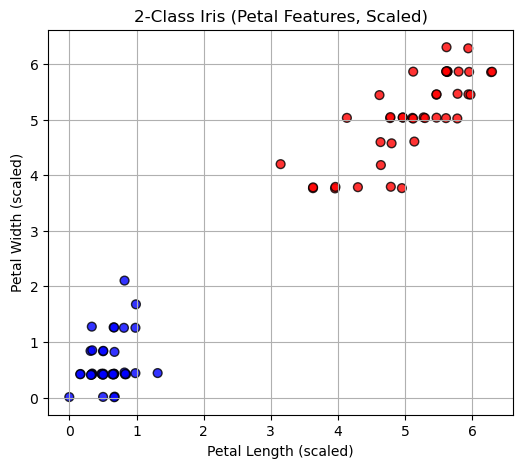

Min value in rescaled X_train: 0.0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

dtype = torch.float32

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Keep only the first two classes (Setosa and Versicolor)
binary_mask = y < 2
X = X[binary_mask]
y = y[binary_mask]

# Use only petal length and petal width
X = X[:, [2, 3]]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Min-Max scaling to [0, 1]
min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)
X_train = 2*math.pi*(X_train - min_vals) / (max_vals - min_vals)
X_test = 2*math.pi*(X_test - min_vals) / (max_vals - min_vals)  # Apply same scaling to test data

# Plot the data
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='bwr',s=10,alpha=0.8)
jitter_scale = 0.01
X_plot = X_train + np.random.normal(scale=jitter_scale, size=X_train.shape)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=y_train,
    cmap='bwr',
    s=40,              # Larger points
    alpha=0.8,         # Semi-transparent
    edgecolors='k'     # Black outlines
)

plt.title("2-Class Iris (Petal Features, Scaled)")
plt.xlabel("Petal Length (scaled)")
plt.ylabel("Petal Width (scaled)")
plt.grid(True)
#plt.savefig(fname='IrisDataset.png',dpi=600)
plt.show()

# Convert test data to torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training
train_data = [
    (torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.float32))
    for x, label in zip(X_train, y_train)
]
test_data = [
    (torch.tensor(x,dtype=torch.float32), torch.tensor(label, dtype=torch.float32))
    for x, label in zip(X_test, y_test)
]
train_loader = DataLoader(train_data, batch_size=25, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=25, shuffle=True, num_workers=4)



# Debug: print min value to verify scaling
print("Min value in rescaled X_train:", np.min(X_train))

In [3]:
n_qubits = 4
total_qubits = 4    ##### Change this to 8 if u want to use the ancillas
folds = 4
dev = qml.device("lightning.qubit", wires=total_qubits, c_dtype=np.complex64)

def strongly_entangling_layer(params, total_qubits=n_qubits):

    for i in range(total_qubits):
        qml.RY(params[i], wires=[i])
    for i in range(total_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[total_qubits - 1, 0])

def zz_featuremap(data_point):

    for i in range(len(data_point)):
        qml.Hadamard(wires=[i])
        qml.PhaseShift(2 * data_point[i], wires=[i])
    qml.CNOT(wires=[0,1])
    qml.PhaseShift(2 * (math.pi - data_point[0]) * (math.pi - data_point[1]), wires=1)
    qml.CNOT(wires=[0,1])

    
@qml.qnode(dev, interface="torch")
def circuit(data_point, params, folds=folds):
    # qml.AmplitudeEmbedding(features=data_point+ 1e-7, wires=[0], pad_with=0., normalize=True)
    zz_featuremap(data_point)
    # qml.AngleEmbedding(features=data_point, wires=range(2), rotation="X")

    for i in range(folds):
        strongly_entangling_layer(params[i], total_qubits=n_qubits)

    output = qml.expval(qml.PauliZ(wires=[0]))

    return output

In [4]:
class BatchLossModel(torch.nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params

    def forward(self,x):
        outputs = torch.stack([circuit(x[i].cpu(), self.params.cpu()) for i in range(x.shape[0])])
        return outputs.to(device, dtype=dtype)
        # expvals = torch.stack([circuit(xi, self.params) for xi in x])   # (B,)
        # # map expval → logits:  atanh(z)
        # logits  = 0.5 * torch.log((1 + expvals) / (1 - expvals))
        # return logits.unsqueeze(1)
    
def evaluate(model, data_loader):
    model.eval()
    batch_preds, batch_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:

            outputs = model(batch_x)
            pred = torch.sigmoid(outputs) > 0.5
            batch_preds.append(pred.cpu())
            batch_labels.append(batch_y.cpu())

    batch_preds = torch.cat(batch_preds)
    batch_labels = torch.cat(batch_labels)
    accuracy = accuracy_score(batch_labels.numpy(), batch_preds.numpy())
    return accuracy

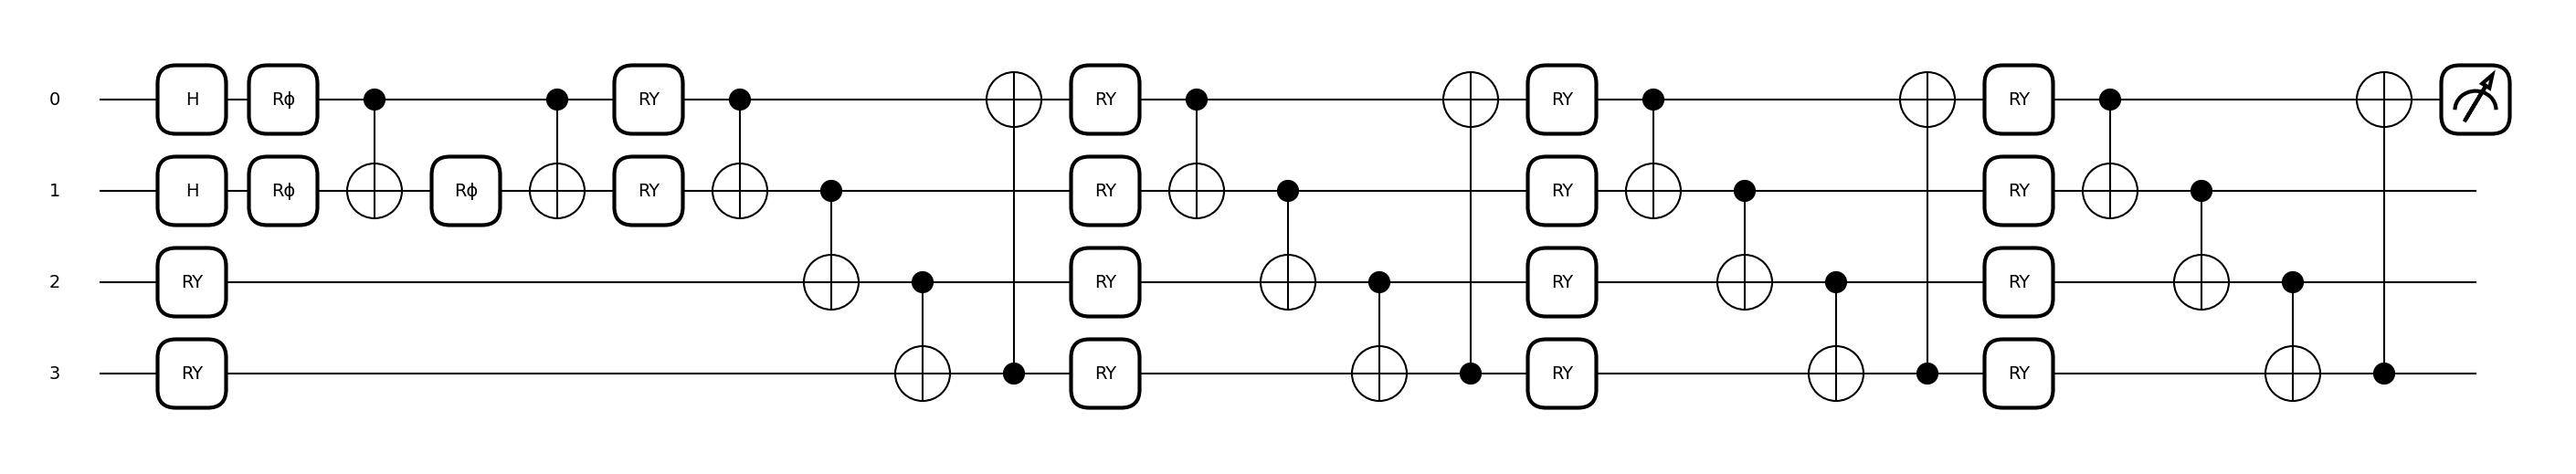

In [5]:
# use seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.mps.manual_seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.mps.deterministc = True
input_params = torch.rand((folds, total_qubits), requires_grad=True, dtype=dtype, device=device)

qml.draw_mpl(circuit, device='default')(X[0],input_params)
plt.show()

In [6]:
weights = input_params
model = BatchLossModel(weights)
opt = torch.optim.Adam([weights],lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
test_accuracies = []

for epoch in range(20):

    model.train()
    for batch_x, batch_y in train_loader:
        # print(batch_y)
        opt.zero_grad()
        circuit_outputs = (model(batch_x) + 1)/2
        # print(circuit_outputs)
        loss = loss_fn(circuit_outputs, batch_y)  # BCEWithLogitsLoss expects logits
        # gradients = torch.autograd.grad(loss, weights)
        # print(gradients)
        loss.backward()
        opt.step()
    
    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch} Test Accuracy: {test_acc} loss: {loss.item()}")

Epoch: 0 Test Accuracy: 0.3 loss: 0.690632700920105
Epoch: 1 Test Accuracy: 0.35 loss: 0.6842557191848755
Epoch: 2 Test Accuracy: 0.35 loss: 0.5556632280349731
Epoch: 3 Test Accuracy: 0.35 loss: 0.9097433090209961
Epoch: 4 Test Accuracy: 0.5 loss: 0.9807146787643433
Epoch: 5 Test Accuracy: 0.65 loss: 0.6861270070075989
Epoch: 6 Test Accuracy: 0.7 loss: 0.6926060914993286
Epoch: 7 Test Accuracy: 0.65 loss: 0.769396185874939
Epoch: 8 Test Accuracy: 0.7 loss: 0.7590731978416443
Epoch: 9 Test Accuracy: 0.7 loss: 0.6919410228729248
Epoch: 10 Test Accuracy: 0.7 loss: 0.5023661851882935
Epoch: 11 Test Accuracy: 0.7 loss: 0.582679271697998
Epoch: 12 Test Accuracy: 0.7 loss: 0.8367440104484558
Epoch: 13 Test Accuracy: 0.65 loss: 0.6875886917114258
Epoch: 14 Test Accuracy: 0.6 loss: 0.7077983021736145
Epoch: 15 Test Accuracy: 0.65 loss: 0.48967036604881287
Epoch: 16 Test Accuracy: 0.65 loss: 0.45076197385787964
Epoch: 17 Test Accuracy: 0.65 loss: 0.6183401346206665
Epoch: 18 Test Accuracy: 0.65 

In [7]:
import json

results = {
    "test_accuracies": test_accuracies,
    "No of Epochs": 20,
    "seed": 42,
    "data sample noise": 0.1
}

results["note"] = (
    "ZZ FeatureMap\n"
)

file_name = f"/Users/akashmalemath/Documents/master_work/qcbm_hiwi/vqc_iris/test_acc_over_epochs/test_accuracies_zzfeaturemap.json"
with open(file_name, "w") as f:
    json.dump(results,f, indent=2)

print(f"Saved results to {file_name}")

Saved results to /Users/akashmalemath/Documents/master_work/qcbm_hiwi/vqc_iris/test_acc_over_epochs/test_accuracies_zzfeaturemap.json


In [8]:
# weights = input_params
# lr = 0.01

# model = BatchLossModel(weights)
# opt = torch.optim.Adam([weights], lr=lr)
# loss_fn = torch.nn.BCEWithLogitsLoss()

# loss_history = []
# min_loss = float('inf')
# optimal_params = torch.zeros((folds, total_qubits), dtype=dtype, device=device)
# n_epochs = 20
# i = 0

# while i < n_epochs:
#     running_loss = 0.0

#     start_time = time.time()
#     model.train()
#     for batch_x, batch_y in train_loader:
        
#         opt.zero_grad()
#         circuit_outputs = (model(batch_x) + 1)/2
#         loss = loss_fn(circuit_outputs, batch_y.squeeze(1))
#         loss.backward()
#         opt.step()

#         running_loss += loss.item()
#     end_time = time.time()

#     print(f"Epoch: {i+1} Loss: {running_loss} Time taken per epoch: {end_time - start_time} seconds")

#     i += 1
#     loss_history.append(running_loss)
#     if running_loss < min_loss:
#         min_loss = running_loss
#         optimal_params = weights.detach().clone()

In [9]:
# plt.plot(loss_history)

# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('BCELogits Loss - Moons Dataset - VQC')
# plt.show()

In [ ]:
model.eval()

all_train_preds = []
all_train_labels = []

with torch.no_grad(): 
    for batch_x, batch_y in train_loader:
        
        outputs = model(batch_x)
        preds = torch.sigmoid(outputs) > 0.5

        all_train_preds.append(preds.cpu())
        all_train_labels.append(batch_y.cpu())

all_train_preds = torch.cat(all_train_preds)
all_train_labels = torch.cat(all_train_labels)


train_accuracy = accuracy_score(all_train_labels.numpy(), all_train_preds.numpy())

print(f"Train Accuracy: {train_accuracy * 100}%")

Train Accuracy: 57.49999999999999%


In [11]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:

        outputs = model(batch_x)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu())
        all_labels.append(batch_y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())    
print(f"Test Accuracy: {accuracy * 100}%")

Test Accuracy: 65.0%


### Decision Boundary

In [12]:
###### Decision Boundary of the trained model
model.eval()

# Get training data for plotting
X_train = X
y_train = y

### build a dense 2-D mesh that covers the feature space
x_min, x_max = X_train[:,0].min()-0.1, X_train[:,0].max()+0.1
y_min, y_max = X_train[:,1].min()-0.1, X_train[:,1].max()+0.1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid   = np.c_[xx.ravel(), yy.ravel()]            # shape (M,2)


### evaluate the trained model ONCE on that grid
g = torch.tensor(grid, dtype=dtype,device=device)

with torch.no_grad():

    logits = model(g)                         # (B,1) or (B,)
    probs  = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)


KeyboardInterrupt: 

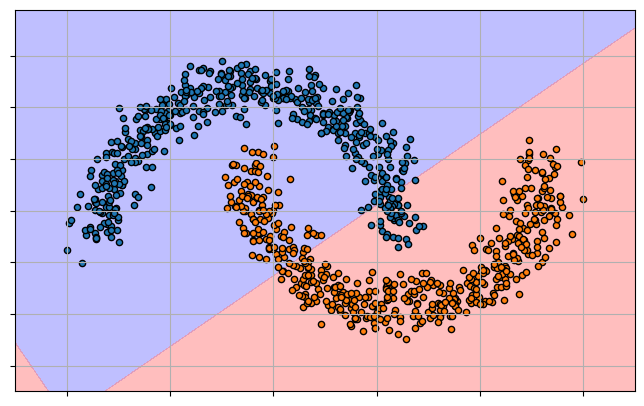

In [ ]:
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.5, cmap='bwr')
plt.scatter(X[y[:,0]==0, 0], X[y[:,0]==0, 1],
            cmap='bwr', edgecolors='k', s=20)
plt.scatter(X[y[:,0]==1, 0], X[y[:,0]==1, 1],
            cmap='bwr', edgecolors='k', s=20)
# plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

plt.xlim(xx.min(), xx.max());  plt.ylim(yy.min(), yy.max())
plt.gca().set_aspect("equal")
plt.grid(True);
# plt.title("Decision boundary of VQC -- ZZ FeatureMap")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
plt.tick_params(axis='both',which='both',labelbottom=False,labelleft=False)
plt.savefig(fname='imgs/vqc_decisionboundary_amplitudeembedding_ancillas_seed42.jpg',dpi=700)
plt.show()